# Group_29 Project Phase 4

## Overview

For the fourth and final phase of our CSI4142 project, we'll be performing some data mining in order to turn our raw data into useful information. As a first step, it's crucial that we identify what exactly it is we wish to predict. In our case, we'll be looking at the `age group of a patient who's tested positive for COVID-19`. As a result, the features we think will best train our model are:

1. Outbreak Related
2. Keyword1
3. Grocery and Pharmacy
4. Parks
5. Total Resolved
6. Total Unresolved
7. Total Fatal

## Connecting to DB

In this first part, we'll be connecting to our database and fetching our labels and features

In [54]:
import sys
sys.path.insert(1, '../lib/python3.9/site-packages')
from configparser import ConfigParser
import psycopg2
import numpy as np
import pandas as pd
import matplotlib as mp
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import recall_score, precision_score
#Can be very helpful to notice any imbalance in classes
from collections import Counter 

Now i can try to connect to my PSQL server

In [55]:
def config(filename='database.ini', section='postgresql'):
    parser = ConfigParser()
    # read config file
    parser.read(filename) 
 
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db

Get the configuration file as a python dictionary

In [56]:
cfg = config()

Establish the connection and create a cursor to the database

In [57]:
try:
    print("Attempting to connect to the database")
    conn = psycopg2.connect(**cfg)
    cursor = conn.cursor()
    print("Connection Successful")
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Attempting to connect to the database
Connection Successful


We'll now attempt to get our data

In [58]:
try:
    #Lets get our data 
    cursor.execute('''
                    select p.outbreak_related, p.age_group, s.keyword1, m.grocery_and_pharmarcy, m.parks,
                    f.total_resolved, f.total_unresolved, f.total_fatal
                    from  covid_19_tracking_fact_table f,
                    patient_dimension p, special_measures_dimension s, mobility_dimension m
                    where f.patient_key =p.patient_key and f.special_measures_key = s.special_measures_key
                    and f.mobility_key = m.mobility_key
                    group by (p.outbreak_related,  p.age_group, s.keyword1, m.grocery_and_pharmarcy, m.parks,
                    f.total_resolved, f.total_unresolved, f.total_fatal)''')



    #Get the complete result set. It will be a list of tuples where each tuple is a row from the result set
    result_list = cursor.fetchall()
        
except (Exception, psycopg2.DatabaseError) as error:
    print(error)
    print("Rolling back...")
    conn.rollback()
    print("Rolled back successfully")

In [59]:
#Ensure to run this cell at the end of all your experiments to close all connections
cursor.close()
conn.close()

In [61]:
result_df = pd.DataFrame(result_list, columns=["outbreak_related","age_group","lockdown_type", "grocery_and_pharmacy",
                                               "parks","total_resolved", "total_unresolved","total_fatal"])

In [62]:
result_df.head()

,outbreak_related,age_group,lockdown_type,grocery_and_pharmacy,parks,total_resolved,total_unresolved,total_fatal
0,False,20s,Grey-Lockdown,-83,-49,1,0,0
1,False,20s,Grey-Lockdown,-83,-49,2,0,0
2,False,20s,Grey-Lockdown,-79,-44,1,0,0
3,False,20s,Grey-Lockdown,-79,-44,2,0,0
4,False,20s,Grey-Lockdown,-79,-44,3,0,0


## Data Summarization

We will now use some summarization techniques to get a better understanding of our data. First and foremost we want to see if there's an imbalance in our classes

In [63]:
Counter(result_df['age_group'])

Counter({'20s': 3266,
         '30s': 2847,
         '40s': 2818,
         '50s': 2891,
         '60s': 2362,
         '70s': 1835,
         '80s': 1894,
         '90+': 1311,
         '<20': 3111})

We notice that there isn't too large of an imbalance between the classes. If we wind up noticing that our results aren't accurate enough, we can consider undersampling, but for now, we believe that this won't be needed

Next, we wanna see if there's any correlation between parks, grocery and pharmacy

<AxesSubplot:xlabel='parks', ylabel='grocery_and_pharmacy'>

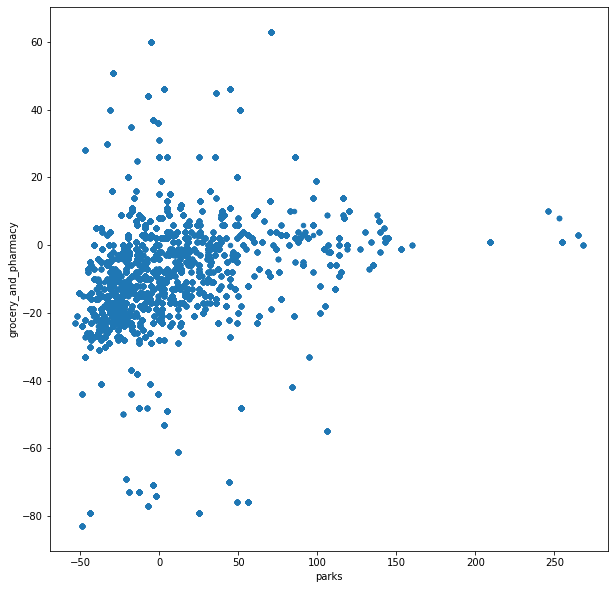

In [64]:
result_df.plot.scatter(x='parks',y='grocery_and_pharmacy',figsize=(10,10))

As expected, the correlation isn't too strong

The last thing we wanna do is check some of the tendencies of our data. Namely, the standard deviation and mean. These values will help give us an understanding of what our data looks like

In [65]:
result_df.mean()

outbreak_related        0.351377
grocery_and_pharmacy   -9.090934
parks                   5.773987
total_resolved          1.852921
total_unresolved        0.003313
total_fatal             0.078576
dtype: float64

In [66]:
result_df.std()

outbreak_related         0.477411
grocery_and_pharmacy    18.026028
parks                   43.138882
total_resolved           1.588666
total_unresolved         0.058240
total_fatal              0.295112
dtype: float64

## Data Transformation notes

1. Since we wish to predict a patient's age group, using totals won't be of much help. Actually, it'll make things much more difficult for us. As a result, we'll need to update our dataframe to go from totals, to individual outcomes. To do so, we'll just need to go row-by-row and, for the outcome where the total is greater than 0, we replace it with 1. We'll also need to change the column names from `total_fatal`, `total_resolved` and `total_unresolved` to just `fatal`,`resolved` and `unresovled`, respectively.

2. When we were working on our phase 2 of the project, we made it a goal of ours to find any missing values in any of the datasets. As a result, our datamart is already populated in a way where no values are missing. Here's how we dealt with missing values:
    1. The weather data had some rows where the value 'E' was placed for all columns, indicating that the weather was not gathered for that day. Since in the four months that we were analysing, only one day had missing values, we decided to simply remove that entry.
    2. For the patients data, there were missing values for the outbreak related column. It was found to be only `yes` or it was blank. For these, it was assumed that if it was not related to an outbreak, that we would assign `no` instead of blank.
    3. Some special measures had missing end dates. For these, we assumed that the end date was 28 days after the start date

3. Our data includes one categorical attribute, namely `gender`. Since the cardenality of `gender` is not too large (three in this case) we'll be using one-hot encoding to deal with it.
4. Since there's a meaningful ranking to the `lockdown_type` features, we're going to treat it as an ordinal attribute. As such, we'll be replacing its values by numbers and then normalize. (** review **)
5. Based on our current understanding of the data, there isn't a clear imbalance between the classes. For now, we won't be performing any under-sampling. If, while training our model, we aren't happy with our results, we can consider under-sampling some of the classes that appear to have larger values than the others.
6. Finally, a word on our feature selection. We wanted to choose features that would best describe a person's age group. For example, we feel like parks, grocery and pharmacy represents a wide spectrum of places visited by different age groups, and so we chose it as a feature. Similarly, an outbreak could have different impacts on different age groups, and so it was also included. As for the outcome, we noticed from the last deliverable that there's a difference in outcome based on a person's age group, and so we think it'll help our model. These features are not set in stone, and we could revisit them after we complete part B to see if we can add/remove some features to improve our results. As of the first iteration the features we're using are:
    1. Outbreak Related
    3. Keyword1
    4. Grocery and Pharmacy
    5. Parks
    6. Total Resolved
    7. Total Unresolved
    8. Total Fatal